In [1]:
from torch_geometric.data import DataLoader
import torch.distributions as D
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors, rdMolTransforms
from rdkit import rdBase
import glob
import os

from deepdock.utils.distributions import *
from deepdock.utils.data import *
from deepdock.models import *

from deepdock.DockingFunction import optimze_conformation
from scipy.optimize import basinhopping, brute, differential_evolution
import copy

# set the random seeds for reproducibility
np.random.seed(123)
torch.cuda.manual_seed_all(123)
torch.manual_seed(123)

%matplotlib inline

RDKit WARNING: [16:13:50] Enabling RDKit 2019.09.1 jupyter extensions


In [2]:
%%time
db_complex = PDBbind_complex_dataset(data_path='../data/dataset_CASF-2016_285.tar', 
                                     min_target_nodes=None, max_ligand_nodes=None)
print('Complexes in CASF2016 Core Set:', len(db_complex))


Complexes in CASF2016 Core Set: 285
CPU times: user 141 ms, sys: 42.4 ms, total: 183 ms
Wall time: 185 ms


In [3]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

ligand_model = LigandNet(28, residual_layers=10, dropout_rate=0.10)
target_model = TargetNet(4, residual_layers=10, dropout_rate=0.10)
model = DeepDock(ligand_model, target_model, hidden_dim=64, n_gaussians=10, dropout_rate=0.10, dist_threhold=7.).to(device)

checkpoint = torch.load('../Trained_models/DeepDock_pdbbindv2019_13K_minTestLoss.chk')
model.load_state_dict(checkpoint['model_state_dict']) 

<All keys matched successfully>

In [4]:
def dock_compound(data, dist_threshold=3., popsize=150):
    np.random.seed(123)
    torch.cuda.manual_seed_all(123)
    torch.manual_seed(123)
    
    model.eval()
    ligand, target, activity, pdbid = data
    ligand, target = ligand.to(device), target.to(device)
    pi, sigma, mu, dist, atom_types, bond_types, batch = model(ligand, target)
    
    pdb_id = pdbid[0]
    real_mol = Chem.MolFromMol2File('../../DeepDock/data/CASF-2016/coreset/' + pdb_id + '/' + pdb_id +'_ligand.mol2',
                                    sanitize=False, cleanupSubstructures=False, removeHs=False)
    opt = optimze_conformation(mol=real_mol, target_coords=target.pos.cpu(), n_particles=1, 
                               pi=pi.cpu(), mu=mu.cpu(), sigma=sigma.cpu(), dist_threshold=dist_threshold)
    
    #Define bounds
    max_bound = np.concatenate([[np.pi]*3, target.pos.cpu().max(0)[0].numpy(), [np.pi]*len(opt.rotable_bonds)], axis=0)
    min_bound = np.concatenate([[-np.pi]*3, target.pos.cpu().min(0)[0].numpy(), [-np.pi]*len(opt.rotable_bonds)], axis=0)
    bounds = (min_bound, max_bound)
    
    # Optimize conformations
    result = differential_evolution(opt.score_conformation, list(zip(bounds[0],bounds[1])), maxiter=500, 
                                    popsize=int(np.ceil(popsize/(len(opt.rotable_bonds)+6))),
                                    mutation=(0.5, 1), recombination=0.8, disp=False, seed=123)
    
    # Get optimized molecule and RMSD
    opt_mol = opt.apply_changes(opt.mol, result['x'])
    ligCoords = torch.stack([torch.tensor(m.GetConformer().GetPositions()[opt.noHidx]) for m in [opt_mol]])
    dist = opt.compute_euclidean_distances_matrix(ligCoords, opt.targetCoords).flatten().unsqueeze(1)
    result['num_MixOfGauss'] = torch.where(dist <= dist_threshold)[0].size(0)
    result['rmsd'] = Chem.rdMolAlign.AlignMol(opt_mol, real_mol, atomMap=list(zip(opt.noHidx,opt.noHidx)))
    result['pdb_id'] = pdb_id
    
    # Get score of real conformation
    ligCoords = torch.stack([torch.tensor(m.GetConformer().GetPositions()[opt.noHidx]) for m in [real_mol]])
    dist = opt.compute_euclidean_distances_matrix(ligCoords, opt.targetCoords).flatten().unsqueeze(1)
    score_real_mol = opt.calculate_probablity(opt.pi, opt.sigma, opt.mu, dist)
    score_real_mol[torch.where(dist > dist_threshold)[0]] = 0.
    result['score_real_mol'] = pdb_id = score_real_mol.reshape(opt.n_particles, -1).sum(1).item()
    del ligCoords, dist, score_real_mol
    
    result['pkx'] = data[2][0].item()
    result['num_atoms'] = real_mol.GetNumHeavyAtoms()
    result['num_rotbonds'] = len(opt.rotable_bonds)
    result['rotbonds'] = opt.rotable_bonds
    #result['num_MixOfGauss'] = mu.size(0)
    
    return result

In [5]:
%%time
loader = DataLoader(db_complex, batch_size=1, shuffle=False)

results = []
i = 0
for data in loader:
    try:
        results.append(dock_compound(data))
        d = {}
        for k in results[0].keys():
            if k != 'jac':
                d[k] = tuple(d[k] for d in results)
        torch.save(d, 'DockingResults_CASF2016_CoreSet.chk')
        results_df = pd.DataFrame.from_dict(d)
        results_df.to_csv('DockingResults_CASF2016_CoreSet.csv', index=False) 
        i += 1
    except:
        print(i, data[3])
        #break
        i += 1

CPU times: user 1d 12h 54min 3s, sys: 46min 14s, total: 1d 13h 40min 18s
Wall time: 9h 59min 55s


In [6]:




[if isinstance(r, list): -r[0] else -r for r in results_df.fun]

results_df.head()

,x,fun,nfev,nit,message,success,num_MixOfGauss,rmsd,pdb_id,score_real_mol,pkx,num_atoms,num_rotbonds,rotbonds
0,"[1.5063067262725696, 0.2133704428551216, 1.508...",[-70.16544231921738],38392,237,Optimization terminated successfully.,True,409,2.099727,4k18,64.253744,NaN,29,5,"[(7, 6, 5, 0), (8, 7, 6, 5), (11, 13, 16, 17),..."
1,"[-3.131853024748477, -0.7319495938580236, 3.08...",[-97.24881673780266],15747,98,Optimization terminated successfully.,True,375,1.293288,4qac,83.284421,NaN,24,3,"[(8, 7, 6, 0), (15, 14, 13, 8), (16, 17, 18, 19)]"
2,"[-2.837375698413872, 1.920415677247661, -2.234...",[-168.15472849991892],22725,144,Optimization terminated successfully.,True,262,1.463300,1o3f,187.713267,NaN,25,3,"[(1, 0, 6, 7), (13, 12, 11, 9), (20, 19, 16, 15)]"
3,"[1.7394099202246427, -2.889091892409308, 0.394...",[-46.61066364180717],13594,85,Optimization terminated successfully.,True,234,1.207122,4ih7,35.630420,NaN,17,2,"[(8, 7, 6, 1), (10, 12, 13, 14)]"
4,"[0.2800270507037714, -1.9041352450017086, 1.38...",[-63.59384324866685],7992,45,Optimization terminated successfully.,True,165,0.000204,3dx1,49.944775,NaN,9,0,[]


(array([78., 49., 28., 20., 15.,  7., 12.,  8.,  4.,  4.]),
 array([ 28. ,  74.8, 121.6, 168.4, 215.2, 262. , 308.8, 355.6, 402.4,
        449.2, 496. ]),
 <a list of 10 Patch objects>)

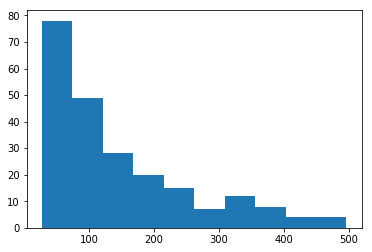

In [38]:
plt.hist(results_df['nit'][results_df.success == True])
#plt.hist(results_df['nit'][results_df.success == False])

(array([34., 27., 53., 43., 39., 13.,  2.,  7.,  3.,  4.]),
 array([6.74349576e-07, 4.56029868e-01, 9.12059061e-01, 1.36808825e+00,
        1.82411745e+00, 2.28014664e+00, 2.73617584e+00, 3.19220503e+00,
        3.64823422e+00, 4.10426342e+00, 4.56029261e+00]),
 <a list of 10 Patch objects>)

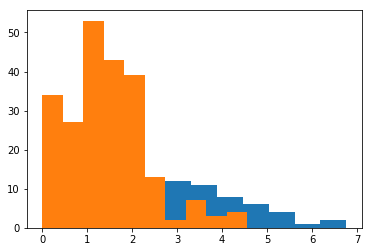

In [49]:
plt.hist(results_df['rmsd'][results_df.success == False])
plt.hist(results_df['rmsd'][results_df.success == True])
#plt.hist(results_df['rmsd'][results_df.success == False])

In [40]:
print('Mean RMSD of all compounds:', results_df.rmsd.mean())
print('Mean RMSD of compounds with succesful optimization:', results_df[results_df.success == True].rmsd.mean())

Mean RMSD of all compounds: 1.8683920926018736
Mean RMSD of compounds with succesful optimization: 1.4235487671127272


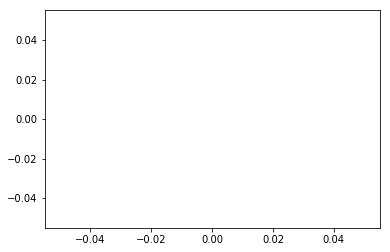

In [24]:
norm_scores = [-r[0] if isinstance(r, list)  else -r for r in results_df.fun[results_df.success == True]]
plt.scatter(norm_scores, results_df[results_df.success == True].pkx)

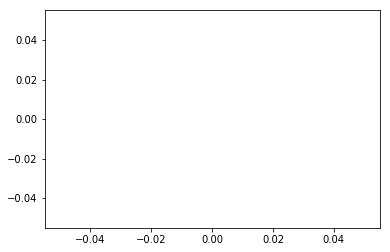

In [26]:
norm_scores = [-r[0] if isinstance(r, list)  else -r for r in results_df.fun[results_df.success == True]]
plt.scatter(norm_scores, results_df[results_df.success == True].pkx)

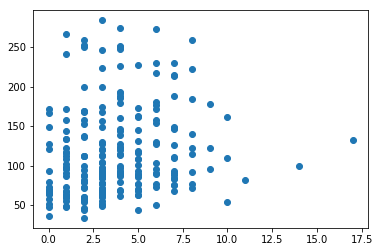

In [27]:
norm_scores = [-r[0] if isinstance(r, list)  else -r for r in results_df.fun[results_df.success == True]]
plt.scatter(results_df[results_df.success == True].num_rotbonds, norm_scores)

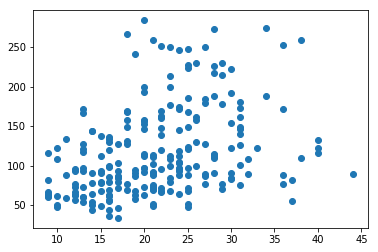

In [28]:
norm_scores = [-r[0] if isinstance(r, list)  else -r for r in results_df.fun[results_df.success == True]]
plt.scatter(results_df[results_df.success == True].num_atoms, norm_scores)

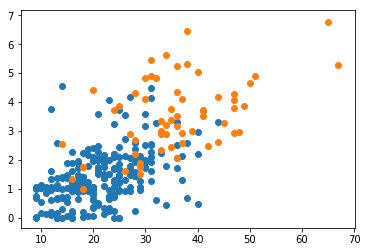

In [43]:
norm_scores = [-r[0] if isinstance(r, list)  else -r for r in results_df.fun[results_df.success == True]]
plt.scatter(results_df[results_df.success == True].num_atoms, results_df[results_df.success == True].rmsd)
plt.scatter(results_df[results_df.success == False].num_atoms, results_df[results_df.success == False].rmsd)

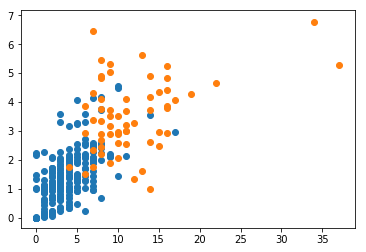

In [42]:
plt.scatter(results_df[results_df.success == True].num_rotbonds, results_df[results_df.success == True].rmsd)
plt.scatter(results_df[results_df.success == False].num_rotbonds, results_df[results_df.success == False].rmsd)

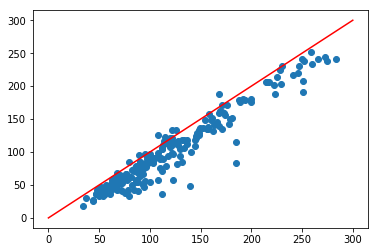

In [45]:
norm_scores = [-r[0] if isinstance(r, list)  else -r for r in results_df.fun[results_df.success == True]]
plt.scatter(norm_scores, results_df[results_df.success == True].score_real_mol)
plt.plot([0,300], [0,300], '-r')

In [18]:
d = torch.load('DockingResults_TestSet.chk')
reults_df = pd.DataFrame.from_dict(d)
reults_df.head()

,x,fun,nfev,nit,message,success,jac,rmsd,pdb_id,score_real_mol
0,"[1.3748057943281191, -0.4826028014294825, 2.13...",[-364.806770723242],7362,56,Optimization terminated successfully.,True,"[-0.0021884716261411086, -0.001716671249596402...",1.062297,3wf6,627.400509
1,"[3.141592653589793, -1.4331719131845528, -2.52...",[-493.99769349980284],117589,500,Maximum number of iterations has been exceeded.,False,"[-0.6910909178259317, 0.0010231815394945443, -...",3.542217,4b9z,782.277607
2,"[-2.109265052871724, 0.3173394855975662, -2.09...",[-1162.5185396000136],240454,500,Maximum number of iterations has been exceeded.,False,"[31.426748137164395, 24.671612663951237, -32.6...",3.126936,1m0b,1604.583213
3,"[-0.15389043897876434, -3.020332654441904, 1.7...",[-74.78615502978923],3666,33,Optimization terminated successfully.,True,"[-0.00011368683772161603, 1.1368683772161603e-...",0.053483,2rk7,60.809820
4,"[-0.8998916306504124, -0.8213899634576136, -0....",[-422.6319121543464],34527,135,Optimization terminated successfully.,True,"[-0.0023362645151792094, 0.01262492332898546, ...",4.171069,4wkp,273.228510


In [ ]:
#%%time
#loader = DataLoader(db_complex_train[5:1000], batch_size=1, shuffle=False)
#data =  next(iter(loader))

pdb_id = data[3][0]
real_mol = Chem.MolFromMol2File('data/pdbbind_v2019_other_refined/' + pdb_id + '/' + pdb_id +'_ligand.mol2')
mol = Chem.MolFromSmiles(Chem.MolToSmiles(Chem.MolFromMol2File('data/pdbbind_v2019_other_refined/' + pdb_id + '/' + pdb_id +'_ligand.mol2')))
Chem.rdchem.Mol.Compute2DCoords(mol)
Chem.rdMolTransforms.CanonicalizeConformer(mol.GetConformer())
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol, randomSeed=123)
AllChem.MMFFOptimizeMolecule(mol)
mol = Chem.RemoveHs(mol)


opt = optimze_conformation(mol=mol, target_coords=torch.tensor([0]), n_particles=1, pi=torch.tensor([0]), mu=torch.tensor([0]), sigma=torch.tensor([0]))


opt_mol = copy.copy(mol)
values = t['x']
        
# aplply rotations
[opt.SetDihedral(opt_mol.GetConformer(), opt.rotable_bonds[r], values[6+r]) for r in range(len(opt.rotable_bonds))]
        
# aplply transformation matrix
rdMolTransforms.TransformConformer(opt_mol.GetConformer(), opt.GetTransformationMatrix(values[:6]))
opt_mol


In [ ]:
import py3Dmol
p = py3Dmol.view(width=400,height=400)
p.addModel(Chem.MolToMolBlock(opt_mol),'sdf')
p.addModel(Chem.MolToMolBlock(real_mol),'sdf')
p.setStyle({'stick':{}})
p.zoomTo()

p.show()